# Explore and prepare the data (20pt)
As the first step, explore the data.

In [1]:
import matplotlib
import sklearn
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.neighbors import KNeighborsClassifier

## (2pt) Load the data. How many responses and variables do we have?

In [4]:
wvs=pd.read_csv("data/wvs.csv.bz2",sep="\t")

In [5]:
wvs.shape

(90350, 328)

There are 90350 responses and 328 variables.

## (3pt) Create a summary table over all responses for V204: 
is abortion justifiable. How many non-missing responses (i.e. positive answers) do you find? Describe the the opinion about the abortion among the global pool of respondents.

In [6]:
v204=wvs.V204

In [7]:
v204.describe()

count    90350.000000
mean         2.946386
std          2.964040
min         -5.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: V204, dtype: float64

In [8]:
#The total positive answer
v204[v204>0].count()

85742

I want to know how many people made which choice, so I will output a dataframe to summarize the results. Also, I will output which choice is the most popular and which least people chose.

In [9]:
max=0
max_choice=0
min_choice=0
min=85742
n=0
values=v204.unique()
#create a dictionary to record every choice and the sum of the people who made this choice.
dic={'choice':[],'count':[]}
for i in values:
    dic['choice'].append(i)
    n=v204[v204==i].count()
    dic['count'].append(n)
    if n>max: 
        max=n
        max_choice=i 
    if n<min: 
        min=n
        min_choice=i
print ("most people (", end="")
print(max,end="")
print (") chose", end=" ")
print(max_choice)

print("least people (", end="")
print(min,end="")
print (") chose", end=" ")
print (min_choice)

most people (40227) chose 1
least people (23) chose -5


In [10]:
summary=pd.DataFrame(dic,columns=['choice','count'])
summary

,choice,count
0,1,40227
1,5,9580
2,-2,1045
3,4,4497
4,6,4395
5,2,7896
6,3,6294
7,10,4067
8,7,3493
9,8,3397


There are 85742 positive answers. The average score of the level of the issue that whether abortion is justifiable is approaximately 3 - more of not justifiable. Most people (40227) chose 1, which means most people contended that abortion is never justifiable. Least people (23) chose -5 - the most vague answer in the survey.

##  (4pt) Now remove missings. We do it in two ways:
(a) remove everything that are not positive integers for V204 and V2 (country).  
(b) for all other variables, remove the missings in the sense of missing value on computer. You may
leave negative answers in the data, otherwise I am afraid your sample size collapses.
What is the final number of observations?

In [11]:
#copy the original dataset
wvs_original=wvs.copy()
#drop missing values
wvs=wvs.dropna(axis=0)
wvs=wvs[(wvs.V204>0) & (wvs.V2>0) ]


##  (2pt) In order to simplify the analysis below, create a new binary variable abortion as
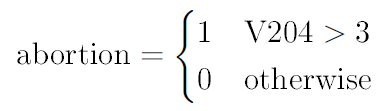

In [12]:
#replace values under conditions
wvs['V204'].mask(wvs['V204']<=3,0,inplace=True)
wvs['V204'].mask(wvs['V204']>3,1,inplace=True)

In [13]:
#test it
wvs.V204.unique()

array([0, 1], dtype=int64)

## (5pt) Compute (pearson) correlation table between abortion and all other variables in the data.
There are many of these!
Present these variables in descending order according to the absolute value of the correlation.
Take a look at a few variables that have strong correlation with abortion. What do these represent?

In [14]:
#transform pandas Series to numpy array
a=wvs.V204.to_numpy()

In [15]:
dict={'variable':[],'correlation':[]}
for column in wvs:
    dict['variable'].append(column)
    b=wvs[column].to_numpy()
    #in case there is inf or nan
    b= np.nan_to_num(b)
    p=stats.pearsonr(a,b)
    dict['correlation'].append(p[0]) #only show the first number of pearson correlation
pearson=pd.DataFrame(dict,columns=['variable','correlation'])

In [16]:
#sort the dataframe in a descending order
pearson.sort_values(by=['correlation'],ascending=False)

,variable,correlation
228,V204,1.000000
229,V205,0.548653
226,V203,0.485419
230,V206,0.446394
231,V207,0.418271
...,...,...
152,V138,-0.142894
298,V255,-0.149844
260,V223,-0.165924
296,V252,-0.191483


## (4pt) convert country code V2 into dummies.   
* First rename V2 to country.  
* Afterwards, remove country variable from the data. How many rows/columns do you have now?  
* How many country dummies does the data contain?  
* Note that get_dummies creates a dummy for every category, so you have to remove one of these
dummies in order to avoid perfect multicollinearity.  

In [17]:
wvs=wvs.rename(columns={"V2":"country"})

There is no country column in the wvs2. I have 386 columns now, 58 more than the original. So there are 59 country dummies the data contain.

In [18]:
wvs2 = pd.get_dummies(wvs, columns = ['country'],drop_first=True)

In [19]:
wvs2.shape

(79267, 384)

# Implement Cross-Validation (40pt)
Now it's time to write your own code that does k-fold CV. I recommend to go the following path:
(3pt) Make it as a function that takes k, the (unfiittted) model, features X and the target y as arguments.

 (10pt) Next, one should randomly shuffle the data. However, it is easier to generate a list of indices, and shuffle those randomly.


(25pt) Loop the following k times  
(a) Select every k-th of your indices for validation data  
(b) For training data, select all indices, except those that went into validation data. Hint: check
out set operations  
(c) Separate the data X and the target y into training/validation parts.  
(d) Fit the model on training data  
(e) Predict outcome on validation data  
(f) Compute the resulting statistic (you may compute more than one).

(2pt) finally, return mean of the statistics.
Note: This is my suggested path but you may follow another one.

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [21]:
def cv(k,model,X, y, data):
    accuracy_scores=[]
    f_scores=[]
    precision_scores=[]
    recall_scores=[]
    a=np.random.choice(len(data),len(data),replace=False)
    for i in range (1,k): #loop k times
        # For training data, select all indices, except those that went into validation data.
        train_index=a[a%k != i] #Select every k-th of your indices for validation data
        valid_index=a[a%k == i]
        #Separate the data X and the target y into training/validation parts.
        X_train=X.iloc[train_index]
        X_valid=X.iloc[valid_index]
        y_train=y.iloc[train_index]
        y_valid=y.iloc[valid_index]
        model.fit(X_train, y_train) # Fit the model on training data
        y1=model.predict(X_valid) # Predict outcome on validation data
        accuracy_scores.append(accuracy_score(y_valid, y1)) #score predict y and validation y
        f_scores.append(f1_score(y_valid,y1))
        precision_scores.append(precision_score(y_valid,y1))
        recall_scores.append(recall_score(y_valid, y1))
    
    dict={'accuracy score':accuracy_scores,'false 1 score':f_scores,
          'precision score': precision_scores,'recall score': recall_scores}
    scores=pd.DataFrame(dict,columns=['accuracy score','false 1 score','precision score','recall score'])
    print (scores)
    print ('mean accuracy score:',np.mean(accuracy_scores),'\nmean false 1 score:',np.mean(f_scores),'\nmean precision score:', np.mean(precision_scores),'\nmean recall score:', np.mean(recall_scores))

# Find the best model (40)

## k-NN (13pt)
First, use k-NN and experiment with a few different k-s.
1. (2pt) Separate your training data into X (features), and y (target). Target will be the abortion
variable, X are all the other features.

In [22]:
wvs_sample=wvs.sample(10000)
y=wvs_sample.V204
X=wvs_sample.drop('V204',1)

2. (2pt) pick a k and set up the k-NN model. Use your freshly-minted CV routine to cross-validate
accuracy and F-score of your k-NN model.
3. (5pt) Try a few different k-NN models (pick different k, choose to normalize/not-to-normalize your
features).
4. (4pt) Present the results from your best k-NN model. Note: as you are using two metrics here, you
may end up with different models performing better according to different measures.

In [23]:
cv(5,KNeighborsClassifier(n_neighbors=1),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7230       0.622101         0.619565      0.624658
1          0.7390       0.648721         0.653117      0.644385
2          0.7190       0.624332         0.600257      0.650418
3          0.7395       0.649630         0.632199      0.668050
mean accuracy score: 0.730125 
mean false 1 score: 0.6361960083216345 
mean precision score: 0.6262844427112344 
mean recall score: 0.6468775452034284


In [24]:
cv(5,KNeighborsClassifier(n_neighbors=5),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7645       0.663331         0.693572      0.635616
1          0.7820       0.687679         0.740741      0.641711
2          0.7600       0.664336         0.667135      0.661560
3          0.7670       0.668563         0.688141      0.650069
mean accuracy score: 0.7683749999999999 
mean false 1 score: 0.6709772495628812 
mean precision score: 0.6973971562083636 
mean recall score: 0.6472391782938246


In [25]:
cv(5,KNeighborsClassifier(n_neighbors=10),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7685       0.641918         0.737123      0.568493
1          0.7800       0.657321         0.787313      0.564171
2          0.7680       0.643625         0.717466      0.583565
3          0.7655       0.641711         0.716724      0.580913
mean accuracy score: 0.7705 
mean false 1 score: 0.6461438285853078 
mean precision score: 0.7396563233687496 
mean recall score: 0.5742856490900379


In [26]:
cv(5,KNeighborsClassifier(n_neighbors=20),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7645       0.641825         0.721368      0.578082
1          0.7605       0.635187         0.738053      0.557487
2          0.7575       0.631739         0.694491      0.579387
3          0.7535       0.623951         0.695578      0.565698
mean accuracy score: 0.7589999999999999 
mean false 1 score: 0.6331754183117437 
mean precision score: 0.7123724170088053 
mean recall score: 0.570163621996985


In [27]:
from sklearn import preprocessing

In [28]:
mNN = KNeighborsClassifier(n_neighbors=5).fit(preprocessing.normalize(X), y)
cv(5,mNN,X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7645       0.663331         0.693572      0.635616
1          0.7820       0.687679         0.740741      0.641711
2          0.7600       0.664336         0.667135      0.661560
3          0.7670       0.668563         0.688141      0.650069
mean accuracy score: 0.7683749999999999 
mean false 1 score: 0.6709772495628812 
mean precision score: 0.6973971562083636 
mean recall score: 0.6472391782938246


4. (4pt) Present the results from your best k-NN model. Note: as you are using two metrics here, you
may end up with different models performing better according to different measures.

best accuracy score

In [29]:
cv(5,KNeighborsClassifier(n_neighbors=10),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7685       0.641918         0.737123      0.568493
1          0.7800       0.657321         0.787313      0.564171
2          0.7680       0.643625         0.717466      0.583565
3          0.7650       0.641221         0.715503      0.580913
mean accuracy score: 0.770375 
mean false 1 score: 0.6460213646101273 
mean precision score: 0.7393510748383033 
mean recall score: 0.5742856490900379


best f1 score

In [30]:
cv(5,KNeighborsClassifier(n_neighbors=5),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.7645       0.663331         0.693572      0.635616
1          0.7820       0.687679         0.740741      0.641711
2          0.7600       0.664336         0.667135      0.661560
3          0.7670       0.668563         0.688141      0.650069
mean accuracy score: 0.7683749999999999 
mean false 1 score: 0.6709772495628812 
mean precision score: 0.6973971562083636 
mean recall score: 0.6472391782938246


## Logistic Regression (9pt)
1. Now repeat the process above with logistic regression. As we have a myriad of features anyway, we
are not going to do any feature engineering. Just a plain logistic regression.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
cv(5,LogisticRegression(solver='liblinear', random_state=0),X,y,wvs_sample)

   accuracy score  false 1 score  precision score  recall score
0          0.8320       0.760684         0.792285      0.731507
1          0.8375       0.769993         0.818045      0.727273
2          0.8140       0.736917         0.748563      0.725627
3          0.7970       0.706223         0.740516      0.674965
mean accuracy score: 0.820125 
mean false 1 score: 0.743454024438277 
mean precision score: 0.7748522827184431 
mean recall score: 0.7148429348470648


## SVM (15pt)
Now repeat the process with support vector machines while choosing between a few different kernels and
kernel options, such as degree for polynomial kernels.
Hint: I have mixed experience with sklearn version of SVM. I recommend to limit the number of
iterations, initially maybe to just 1000, in order to ensure your model actually terminates.
1. (14pt) pick a kernel and repeat the process above.
Note that some kernels are slower than others, so be careful.

In [33]:
cv(5,SVC(kernel='poly',degree=1,max_iter=1000),X,y,wvs_sample)

C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


   accuracy score  false 1 score  precision score  recall score
0          0.5825       0.616092         0.463668      0.917808
1          0.5560       0.617900         0.455584      0.959893
2          0.4975       0.572522         0.412125      0.937326
3          0.4935       0.575262         0.412756      0.948824
mean accuracy score: 0.532375 
mean false 1 score: 0.5954441278925943 
mean precision score: 0.4360330539682403 
mean recall score: 0.9409628789035294


In [34]:
cv(5,SVC(kernel='sigmoid',gamma=0.8,max_iter=1000),X,y,wvs_sample)

C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


   accuracy score  false 1 score  precision score  recall score
0          0.3650       0.534799           0.3650           1.0
1          0.3740       0.544396           0.3740           1.0
2          0.3590       0.528330           0.3590           1.0
3          0.3615       0.531032           0.3615           1.0
mean accuracy score: 0.36487499999999995 
mean false 1 score: 0.5346390158299195 
mean precision score: 0.36487499999999995 
mean recall score: 1.0


In [35]:
cv(5,SVC(kernel='rbf',gamma=1,max_iter=1000),X,y,wvs_sample)

C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Zhu\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


   accuracy score  false 1 score  precision score  recall score
0           0.510       0.580479         0.422167      0.928767
1           0.507       0.580426         0.425718      0.911765
2           0.494       0.570458         0.410256      0.935933
3           0.488       0.562767         0.407041      0.911480
mean accuracy score: 0.49974999999999997 
mean false 1 score: 0.5735325634927373 
mean precision score: 0.41629563018308224 
mean recall score: 0.9219862303693254


2. (2pt) If your models worked like mine, you may have noticed that while accuracy seems all right,
precision and recall are rather low. Explain what does such a phenomenon mean.

Most of the participant made postive choices upon this question.A situation of Low Precision emerges when very few of your positive predictions are true, and Low Recall occurs if most of your positive values are never predicted.

## Compare the models (3pt)
1. (2pt) Finally, compare the models. Which ones performed the best in terms of accuracy? Which
ones in terms of F-score? Did you encounter other kind of issues with certain models? Which models
were fast and which ones slow?
2. (1pt) If you have to repeat the exercise with a single model (and you have, see below), which one
will you pick?

* By using 10000 samples from the original dataset, logistic regression is the best in terms of both accuracy and F-score. I changed the number of my samples during the process and I found that the best models are different. Sometimes the best model is the kNN model in different k. SVM is snow and logistic regression is the fastest.  
* I would choose the kNN model.

# How large a role does country play? (20pt)
Here we switch from machine learning to social sciences. Public opinion differs from country to country,
but also inside the countries. Does the fact that we include country code in data help us to substantially
improve the predictions?
You pick the best ML method from above. You estimate two sets of models: one with country
information included, and one where it is removed. Is the former noticeably better than the latter?
1. (10pt) Pick your best ML method based you designed above. Cross-validate the accuracy of abortion
variable using all the features, including country dummies and report the accuracy. Essentially you
repeat here what you did above, so you can also just copy the result from above.
2. (15pt) Now remove all the country dummies, but keep the other variables intact. And repeat.

In [41]:
y=wvs2.V204
X=wvs2.drop('V204',1)

In [42]:
cv(5,LogisticRegression(solver='liblinear', random_state=0),X,y,wvs2)

   accuracy score  false 1 score  precision score  recall score
0        0.837139       0.766038         0.799206      0.735514
1        0.834101       0.764210         0.794853      0.735843
2        0.836939       0.763646         0.799540      0.730837
3        0.831830       0.760725         0.794973      0.729306
mean accuracy score: 0.835002252903356 
mean false 1 score: 0.763655022662412 
mean precision score: 0.7971429651300777 
mean recall score: 0.7328749380678234


In [38]:
wvs_new=wvs.drop(['country'],axis=1)

In [39]:
y=wvs_new.V204
X=wvs_new.drop('V204',1)
cv(5,LogisticRegression(solver='liblinear', random_state=0),X,y,wvs_new)

   accuracy score  false 1 score  precision score  recall score
0        0.834174       0.760761         0.797406      0.727336
1        0.832839       0.761990         0.794085      0.732390
2        0.831767       0.756772         0.790135      0.726111
3        0.828991       0.756402         0.791463      0.724316
mean accuracy score: 0.8319429418037461 
mean false 1 score: 0.7589811997601386 
mean precision score: 0.7932720878091655 
mean recall score: 0.727538190555903


3. (5pt) Comment what you found. Does country information help to noticeably improve the prediction?  
**The sample of the original data shows a accuracy score of about 0.82. The data without any country or country dummies has an accuracy score of 0.8319, higher than the former one. And the data including dummies is the highest between the three all. So the country information helps to improve the prediction and the country variable should better be dummied.**